In [8]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import mnist,fashion_mnist
import cv2
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Conv2D,Dense,GlobalAveragePooling2D,MaxPooling2D,Dropout,Input
from tensorflow.keras.models import Model

In [9]:
(trainX,trainY),(testX,testY)=fashion_mnist.load_data()

In [10]:
trainX=trainX/255.0
testX=testX/255.0

In [11]:
trainX=np.expand_dims(trainX,axis=-1)
testX=np.expand_dims(testX,axis=-1)

In [12]:
pairImages=[]
pairLabels=[]


In [13]:
def make_pairs(images, labels):
    # Initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    # Calculate the total number of classes present in the dataset and then build a list of indexes
    # for each class label that provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    # Loop over all images
    for idxA in range(len(images)):
        # Grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        # Randomly pick an image that belongs to the *same* class label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        # Prepare a positive pair and update the images and labels lists, respectively
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        # Grab the indices for each of the class labels *not* equal to the current label and randomly pick an image
        # corresponding to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        # Prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    # Return a 2-tuple of the image pairs and labels
    return np.array(pairImages), np.array(pairLabels)

In [14]:
def euclidean_distance(vectors):

    (featsA, featsB) = vectors

    return tf.math.reduce_euclidean_norm(featsA - featsB, axis = 1, keepdims = True)

In [15]:
'''def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true,y_pred):
        y_true=tf.cast(y_true,y_pred.dtype)
        squaredPreds=tf.square(y_pred)
        squaredMargin=tf.square(tf.maximum(margin-y_pred,0))
        loss=tf.reduce_mean(y_true*squaredPreds+(1-y_true)*squaredMargin)
        return loss
    return contrastive_loss'''

'def contrastive_loss_with_margin(margin):\n    def contrastive_loss(y_true,y_pred):\n        y_true=tf.cast(y_true,y_pred.dtype)\n        squaredPreds=tf.square(y_pred)\n        squaredMargin=tf.square(tf.maximum(margin-y_pred,0))\n        loss=tf.reduce_mean(y_true*squaredPreds+(1-y_true)*squaredMargin)\n        return loss\n    return contrastive_loss'

In [16]:
def contrastive_loss(y_true,y_pred):
    margin=1
    y_true=tf.cast(y_true,y_pred.dtype)
    squaredPreds=tf.square(y_pred)
    squaredMargin=tf.square(tf.maximum(margin-y_pred,0))
    loss=tf.reduce_mean(y_true*squaredPreds+(1-y_true)*squaredMargin)
    return loss

In [17]:
'''class ContrastiveLoss(Loss):
    def __init__(self,margin):
        super().__init__()
        self.margin=margin
    def call(self,y_true,y_pred):
        y_true=tf.cast(y_true,y_pred.dtype)
        squaredPreds=tf.square(y_pred)
        squaredMargin=tf.square(tf.maximum(self.margin-y_pred,0))
        loss=tf.reduce_mean(y_true*squaredPreds+(1-y_pred)*squaredMargin)
        return loss'''


'class ContrastiveLoss(Loss):\n    def __init__(self,margin):\n        super().__init__()\n        self.margin=margin\n    def call(self,y_true,y_pred):\n        y_true=tf.cast(y_true,y_pred.dtype)\n        squaredPreds=tf.square(y_pred)\n        squaredMargin=tf.square(tf.maximum(self.margin-y_pred,0))\n        loss=tf.reduce_mean(y_true*squaredPreds+(1-y_pred)*squaredMargin)\n        return loss'

In [18]:
'''def build_siamese_model(inputShape, embeddingDim=48):    # classification & binary_crossentropy
    # Specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    # Define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # Second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    # Prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # Build the model
    model = Model(inputs, outputs)
    # Return the model to the calling function
    return model'''

'def build_siamese_model(inputShape, embeddingDim=48):    # classification & binary_crossentropy\n    # Specify the inputs for the feature extractor network\n    inputs = Input(inputShape)\n    # Define the first set of CONV => RELU => POOL => DROPOUT layers\n    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)\n    x = MaxPooling2D(pool_size=(2, 2))(x)\n    x = Dropout(0.3)(x)\n    # Second set of CONV => RELU => POOL => DROPOUT layers\n    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)\n    x = MaxPooling2D(pool_size=2)(x)\n    x = Dropout(0.3)(x)\n    # Prepare the final outputs\n    pooledOutput = GlobalAveragePooling2D()(x)\n    outputs = Dense(embeddingDim)(pooledOutput)\n    # Build the model\n    model = Model(inputs, outputs)\n    # Return the model to the calling function\n    return model'

In [19]:
def build_siamese_model(inputShape, embeddingDim=48):
    # Specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    # Define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same")(inputs)
    x=layers.Lambda(lambda t:tf.maximum(0.0,t))(x)        # Relu
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # Second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same")(x)
    x=layers.Lambda(lambda t:tf.maximum(0.0,t))(x)        # RElu
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    # Prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # Build the model
    model = Model(inputs, outputs)
    # Return the model to the calling function
    return model

In [20]:
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

In [21]:
pairTrain.shape

(120000, 2, 28, 28, 1)

In [22]:
labelTrain.shape

(120000, 1)

In [23]:
IMG_SHAPE = (28, 28, 1)
imgA=layers.Input(IMG_SHAPE)
imgB=layers.Input(IMG_SHAPE)
featureExtractor=build_siamese_model(IMG_SHAPE)
featsA=featureExtractor(imgA)
featsB=featureExtractor(imgB)
distance=layers.Lambda(euclidean_distance)([featsA,featsB])
#outputs=Dense(1,activation='sigmoid')(distance)   # for classification
model = models.Model(inputs=[imgA, imgB], outputs=distance)

In [17]:
model.compile(loss=contrastive_loss,optimizer="adam")

In [18]:
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain,
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest),
                    batch_size=64, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 55s 26ms/step - loss: 0.1534 - val_loss: 0.1352
Epoch 2/20
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1327 - val_loss: 0.1279
Epoch 3/20
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1275 - val_loss: 0.1243
Epoch 4/20
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1244 - val_loss: 0.1227
Epoch 5/20
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1224 - val_loss: 0.1234
Epoch 6/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1205 - val_loss: 0.1163
Epoch 7/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1196 - val_loss: 0.1172
Epoch 8/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1185 - val_loss: 0.1140
Epoch 9/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1179 - val_loss: 0.1139
Epoch 10/20
1875/1875 [==============================] - 50s 27m

In [7]:
def plot_training(H):
    # Construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.legend()
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")

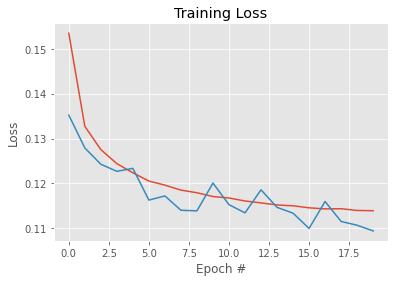

In [20]:
plot_training(history)

### Contrastive Loss from Tensorflow Addons

In [6]:
import tensorflow_addons as tfa

In [24]:
model.compile(loss=tfa.losses.ContrastiveLoss(),optimizer="adam")

In [25]:
history2 = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain,
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest),
                    batch_size=64, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 60s 28ms/step - loss: 0.1509 - val_loss: 0.1341
Epoch 2/20
1875/1875 [==============================] - 50s 26ms/step - loss: 0.1314 - val_loss: 0.1230
Epoch 3/20
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1269 - val_loss: 0.1231
Epoch 4/20
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1240 - val_loss: 0.1223
Epoch 5/20
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1224 - val_loss: 0.1176
Epoch 6/20
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1207 - val_loss: 0.1146
Epoch 7/20
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1199 - val_loss: 0.1123
Epoch 8/20
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1191 - val_loss: 0.1169
Epoch 9/20
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1180 - val_loss: 0.1127
Epoch 10/20
1875/1875 [==============================] - 51s 27m

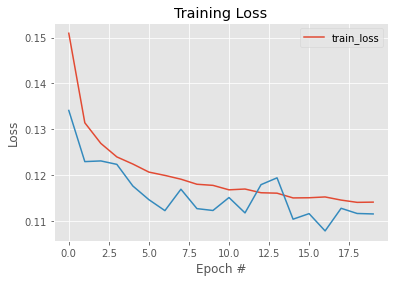

In [27]:
plot_training(history2)